###Setup Notebook
Import all required libaries and access google drive contents

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2

In [2]:
!nvidia-smi

Thu Jan 14 18:03:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
models_filepath = '/content/gdrive/My Drive/ECE496 Capstone/Models/'
streets_dataset_filepath = '/content/gdrive/My Drive/ECE496 Capstone/Datasets/STREETS'

###Load Data
Load images and mask from STREETS dataset

In [5]:
import os
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import torchvision.transforms.functional as TF
from sklearn.utils import shuffle

"""
convert mask to binary mask using threshold
"""
def apply_binary_image_thresholding(mask, threshold=0.5, cuda_allow=False):
    if mask.is_cuda:
        ones_array = torch.ones(mask.shape, device=torch.device('cuda:0'))
        zeros_array = torch.zeros(mask.shape, device=torch.device('cuda:0'))
        threshold_array = ones_array * threshold
    else:
        ones_array = torch.ones(mask.shape)
        zeros_array = torch.zeros(mask.shape)
        threshold_array = ones_array * threshold

    cond = torch.greater(mask, threshold_array)
    mask = torch.where(cond, ones_array, zeros_array)
    torch.cuda.empty_cache() # Clean up gpu cache
    return mask

def random_crop(img, mask, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    assert img.shape[1] == mask.shape[1]
    assert img.shape[2] == mask.shape[2]
    x = random.randint(0, img.shape[2] - width)
    y = random.randint(0, img.shape[1] - height)
    img = img[:, y:y+height, x:x+width]
    mask = mask[:, y:y+height, x:x+width]
    return img, mask

class StreetsDataset(Dataset):
    def __init__(self, image_paths, target_paths, random_augments=False, bin_threshold=0.5):
        self.num_samples = len(image_paths)
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.bin_threshold = bin_threshold
        
        self.random_augments = random_augments
        self.transformsFirst = transforms.Compose([transforms.Resize((256, 512)), transforms.ToTensor()])
        self.transformsSecond = transforms.Compose([transforms.Resize((128, 256))])

    def __getitem__(self, index):
        if index >= self.num_samples:
            index = index - self.num_samples
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])

        t_image = self.transformsFirst(image)
        t_mask = self.transformsFirst(mask)
        
        if self.random_augments:
            # Random horizontal flipping
            if random.random() < 0.4:
                t_image = TF.hflip(t_image)
                t_mask = TF.hflip(t_mask)

            # Random vertical flipping
            if random.random() < 0.6:
                t_image = TF.vflip(t_image)
                t_mask = TF.vflip(t_mask)

            # Random cropping
            if random.random() < 0.4:
                t_image, t_mask = random_crop(t_image, t_mask, 256, 128)

        t_image = self.transformsSecond(t_image)
        t_mask = self.transformsSecond(t_mask)

        t_mask = apply_binary_image_thresholding(t_mask, threshold=self.bin_threshold)

        return t_image, t_mask

    def __len__(self):
        if self.random_augments:
           return len(self.image_paths)*2 
        return len(self.image_paths)

def get_data_loaders_and_dataset(data_paths, target_paths, batch_size=16, train_split=70, val_split=15):
    data_paths = sorted(data_paths)
    target_paths = sorted(target_paths)

    num_data = len(data_paths)

    train_idx = int(num_data * train_split/100.)
    val_idx = train_idx + int(num_data * val_split/100.)

    data_paths, target_paths = shuffle(data_paths, target_paths)

    train_ds = StreetsDataset(data_paths[:train_idx], target_paths[:train_idx], True)
    val_ds = StreetsDataset(data_paths[train_idx:val_idx], target_paths[train_idx:val_idx])
    test_ds = StreetsDataset(data_paths[val_idx:], target_paths[val_idx:])

    print('{} train, {} validation, {} testing samples'.format(len(train_ds), len(val_ds), len(test_ds)))

    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

In [6]:
streets_ds_images_filepath = streets_dataset_filepath + '/images/*'
streets_ds_target_filepath = streets_dataset_filepath + '/mask/*'


streets_data_paths = glob.glob(streets_ds_images_filepath)
streets_target_paths = glob.glob(streets_ds_target_filepath)

num_streets_data = len(streets_data_paths)
num_streets_target = len(streets_target_paths)

print('Found {} data / {} targets in {}'.format(num_streets_data, num_streets_target, streets_dataset_filepath))
assert num_streets_data == num_streets_target, 'Unequal number of images and masks for STREETS dataset'

# split data into train/validation/test 70-15-15
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_data_loaders_and_dataset(\
                data_paths=streets_data_paths, target_paths=streets_target_paths, \
                batch_size=16, train_split=70, val_split=15)

Found 2949 data / 2949 targets in /content/gdrive/My Drive/ECE496 Capstone/Datasets/STREETS
4128 train, 442 validation, 443 testing samples


###View target masks on image
Do a sanity check on data by checking first image and mask target 

In [7]:
def display_masked_image(img, mask, display=True):
    res = img
    res[0] = img[0] + mask[0] * 0.6   # make mask items red
    res[res > 1] = 1

    if res.shape[0] == 1:
        res = np.squeeze(res, axis=0)
    else:
        res = np.moveaxis(res, 0, -1)

    if display:
        plt.imshow(res)
        plt.show()
    return res

In [8]:
def display_one_image_from_loader(loader):        
    dataiter_train = iter(loader)
    images, targets = dataiter_train.next() 

    images = images.numpy()[0]
    masks = targets.numpy()[0]
    display_masked_image(images, masks)

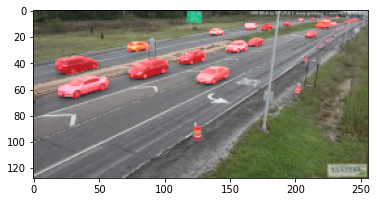

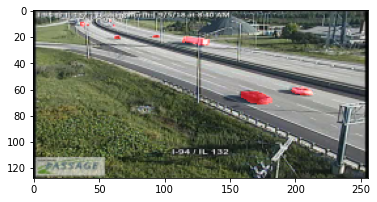

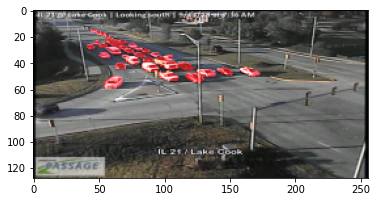

In [9]:
display_one_image_from_loader(train_loader)
display_one_image_from_loader(val_loader)
display_one_image_from_loader(test_loader)

###Define Models

###### very simple convolutional autoencoder - tried and works (very bad)

In [10]:
class Simple_Autoencoder(nn.Module):
    def __init__(self):
        super(Simple_Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

###### vgg16 pretrained - tried and works

In [11]:
encode_out = []
def hook(module, input, output):
	encode_out.append(output)

class TrafficCamera_Vgg(nn.Module):
  def __init__(self):
    super(TrafficCamera_Vgg, self).__init__()

    vgg = torchvision.models.vgg.vgg16(pretrained=True)

    # Maxpool output layers
    # NEED TO ADJUST ENCODING OUTPUT LAYERS
    # vgg19 = [4,9,18,27,36]
    # vgg16 = [4,9,16,23,30]
    # vgg11 = [2,5,10,15,20]
    self.encoder_out_layers = [4,9,16,23,30]

    self.vgg = vgg

    # Freeze weights
    for param in self.vgg.features.parameters():
      param.requires_grad = False

    # Save intermediate output values
    for i in self.encoder_out_layers:
      self.vgg.features[i].register_forward_hook(hook)

    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer1 = nn.BatchNorm2d(512)
    self.deconv_dropout1 = nn.Dropout(p=0.5)

    self.deconv2 = nn.ConvTranspose2d(512+512, 256, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer2 = nn.BatchNorm2d(256)
    self.deconv_dropout2 = nn.Dropout(p=0.5)

    self.deconv3 = nn.ConvTranspose2d(256+256, 128, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer3 = nn.BatchNorm2d(128)
    self.deconv_dropout3 = nn.Dropout(p=0.5)

    self.deconv4 = nn.ConvTranspose2d(128+128, 64, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer4 = nn.BatchNorm2d(64)
    self.deconv_dropout4 = nn.Dropout(p=0.5)

    self.deconv5 = nn.ConvTranspose2d(64+64, 3, 3, stride=2, padding=1, output_padding=1)
    self.deconv_bn_layer5 = nn.BatchNorm2d(3)
    self.deconv_dropout5 = nn.Dropout(p=0.5)

    self.deconv6 = nn.ConvTranspose2d(3+3, 1, 3, stride=1, padding=1)
    self.deconv_bn_layer6 = nn.BatchNorm2d(1)
    self.deconv_dropout6 = nn.Dropout(p=0.5)

  def forward(self, img):
    encode_out.clear()
    out = self.vgg.features(img)

    out = F.relu(self.deconv_bn_layer1(self.deconv1(encode_out[-1])))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, encode_out[-2]), 1)
    out = F.relu(self.deconv_bn_layer2(self.deconv2(out)))
    out = self.deconv_dropout1(out)


    out = torch.cat((out, encode_out[-3]),1)
    out = F.relu(self.deconv_bn_layer3(self.deconv3(out)))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, encode_out[-4]),1)
    out = F.relu(self.deconv_bn_layer4(self.deconv4(out)))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, encode_out[-5]),1)
    out = F.relu(self.deconv_bn_layer5(self.deconv5(out)))
    out = self.deconv_dropout1(out)

    out = torch.cat((out, img),1)
    out = self.deconv_bn_layer6(self.deconv6(out))
    out = self.deconv_dropout1(out)

    return out

###Define Loss Function

###### Using BCE and Dice Coefficient as loss function
Loss function from: https://becominghuman.ai/image-masking-challenge-a-kaggle-competition-5a66f30aa335
Sample code taken from: https://www.kaggle.com/kmader/vgg16-u-net-on-carvana
Dice coefficient vs Jaccard Index - https://stats.stackexchange.com/questions/238684/what-are-the-difference-between-dice-jaccard-and-overlap-coefficients

In [12]:
def get_dice_coeff(mask_true, mask_pred, epsilon=1e-10):
    intersection = torch.sum(mask_true * mask_pred, axis=(1,2,3))
    union = torch.sum(mask_true, axis=(1,2,3)) + torch.sum(mask_pred, axis=(1,2,3))
    return torch.mean(2. * intersection / (union + epsilon), axis=0)

class LossBCEDice:
    """
    Loss defined as BCE + (1 - Dice_Coeff)
    """
    def __init__(self, bce_weight=1):
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight

    def __call__(self, outputs, targets):
        binary_outputs = apply_binary_image_thresholding(outputs, cuda_allow=True)
        dice_coeff = get_dice_coeff(targets, binary_outputs)
        loss = self.bce_weight * self.bce_loss(outputs, targets) + (1 - dice_coeff)
        return loss

def get_accuracy_and_loss(dataset, criterion, model, batch_size=32, num_workers=4):
    losses, accuracy = [], []
    sigmoid = nn.Sigmoid()

    for imgs, labels in iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)):
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        out = model(imgs)
        loss_batch = criterion(out, labels)
        losses.append(loss_batch.detach().item())

        out = sigmoid(out)
        out = apply_binary_image_thresholding(out, cuda_allow=True)
        acc_batch = get_dice_coeff(labels, out, epsilon=1e-10)
        # acc_batch = torch.sum(out == labels, dtype=torch.float) / torch.numel(out)
        accuracy.append(acc_batch)

    acc = torch.mean(torch.tensor(accuracy))
    loss = torch.mean(torch.tensor(losses))

    torch.cuda.empty_cache() # Clean up gpu cache

    return acc, loss

### Training Function

In [14]:
#Garbage Collection
import gc

def train(model, train_dataset, val_dataset, learning_rate, batch_size, num_epochs, model_name=""):
    if torch.cuda.is_available():
      model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = LossBCEDice()

    best_val_acc = 0.
    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [],[]
    for epoch in range(num_epochs):
        
        model.train()
        gc.collect() # Garbage Collection
        
        # if cuda is still running out of memory try adjusting the dataloader
        for imgs, labels in iter(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)):
            imgs = imgs.cuda()      
            labels = labels.cuda()
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        model.eval()
        torch.cuda.empty_cache() # Clean up gpu cache
        
        # save the current training information 
        iters.append(epoch)

        # Validation Loss and Accuracy
        jaccard = []
        losses = []

        val_acc_epoch, val_loss_epoch = get_accuracy_and_loss(val_dataset, criterion, model, batch_size=batch_size, num_workers=4)
        val_acc.append(val_acc_epoch)
        val_loss.append(val_loss_epoch)

        train_acc_epoch, train_loss_epoch = get_accuracy_and_loss(train_dataset, criterion, model, batch_size=batch_size, num_workers=4)
        train_acc.append(train_acc_epoch)
        train_loss.append(train_loss_epoch)

        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch         
            torch.save(model.state_dict(), models_filepath + model_name + '_best')

        print('Epoch {}, Train Acc: {:.4f} Loss: {:.4f} Valid Acc: {:.4f} Loss: {:.4f}'.format(epoch, train_acc_epoch, train_loss_epoch, val_acc_epoch, val_loss_epoch))
        
    # plotting
    plt.title("Training Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Loss")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    acc_loss_filepath = '/content/gdrive/My Drive/ECE496 Capstone/Models/Accuracy_and_Loss'

    np.savetxt("{}/{}_train_loss.csv".format(acc_loss_filepath, model_name), train_loss)
    np.savetxt("{}/{}_train_acc.csv".format(acc_loss_filepath, model_name), train_acc)
    np.savetxt("{}/{}_val_loss.csv".format(acc_loss_filepath, model_name), val_loss)
    np.savetxt("{}/{}_val_acc.csv".format(acc_loss_filepath, model_name), val_acc)

    torch.save(model.state_dict(), models_filepath + model_name + ".pt")
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Training Model
uncomment the line below the dotted line to actually train

4128 train, 442 validation, 443 testing samples


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Epoch 0, Train Acc: 0.3887 Loss: 1.5947 Valid Acc: 0.3923 Loss: 1.5925
Epoch 1, Train Acc: 0.5230 Loss: 1.5018 Valid Acc: 0.5290 Loss: 1.4979
Epoch 2, Train Acc: 0.5284 Loss: 1.4433 Valid Acc: 0.5321 Loss: 1.4393
Epoch 3, Train Acc: 0.5753 Loss: 1.3926 Valid Acc: 0.5867 Loss: 1.3873
Epoch 4, Train Acc: 0.5831 Loss: 1.3432 Valid Acc: 0.5861 Loss: 1.3379
Epoch 5, Train Acc: 0.5552 Loss: 1.3223 Valid Acc: 0.5551 Loss: 1.3166
Epoch 6, Train Acc: 0.5798 Loss: 1.2982 Valid Acc: 0.5895 Loss: 1.2936
Epoch 7, Train Acc: 0.6142 Loss: 1.2687 Valid Acc: 0.6252 Loss: 1.2659
Epoch 8, Train Acc: 0.6259 Loss: 1.2411 Valid Acc: 0.6371 Loss: 1.2397
Epoch 9, Train Acc: 0.6252 Loss: 1.2265 Valid Acc: 0.6344 Loss: 1.2265
Epoch 10, Train Acc: 0.6184 Loss: 1.1972 Valid Acc: 0.6332 Loss: 1.1983
Epoch 11, Train Acc: 0.6314 Loss: 1.1640 Valid Acc: 0.6384 Loss: 1.1656
Epoch 12, Train Acc: 0.6422 Loss: 1.0854 Valid Acc: 0.6513 Loss: 1.0900
Epoch 13, Train Acc: 0.6346 Loss: 1.0866 Valid Acc: 0.6405 Loss: 1.0898
E

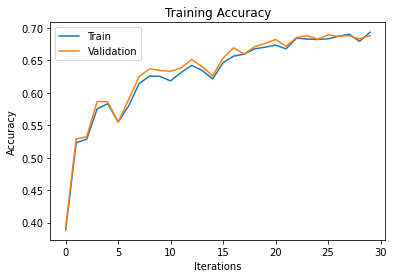

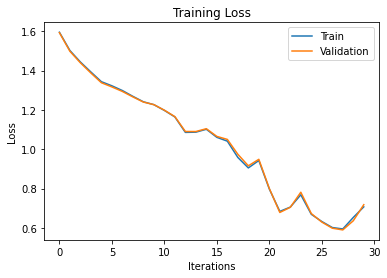

Final Training Accuracy: 0.6933596134185791
Final Validation Accuracy: 0.688019335269928


In [15]:
batch_size = 16
num_epochs = 30
learning_rate = 0.001

debug_data_paths = streets_data_paths[:200]
debug_target_paths = streets_target_paths[:200]

# split data into train/validation/test 70-15-15
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_data_loaders_and_dataset(\
                data_paths=streets_data_paths, target_paths=streets_target_paths, \
                batch_size=batch_size, train_split=70, val_split=15)

model = TrafficCamera_Vgg()
model_name = 'vgg_augmented'
model_save_name = '{}_{}_{}_{}'.format(model_name, batch_size, num_epochs, learning_rate)
#------------------------------------ uncomment to train ------------------------------------------------------------------------
train(model, train_ds, val_ds, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, model_name=model_save_name)

###Testing Model
Find accuracy of test set and look at some examples

In [ ]:
# Load saved model
model = TrafficCamera_Vgg()
model_name = 'vgg'
batch_size = 16
num_epochs = 30
learning_rate = 0.001
model_save_name = '{}_{}_{}_{}_best'.format(model_name, batch_size, num_epochs, learning_rate)

model.load_state_dict(torch.load(models_filepath + model_save_name))
model.eval()

if torch.cuda.is_available():
    model.cuda()

In [ ]:
test_acc, test_loss = get_accuracy_and_loss(test_ds, LossBCEDice(), model, batch_size=16, num_workers=4)
print('Testing Accuracy {:.4f} | Testing Loss {:.4f} using model "{}"'.format(test_acc, test_loss, model_name))

Testing Accuracy 0.7343 | Testing Loss 0.4529 using model "vgg"


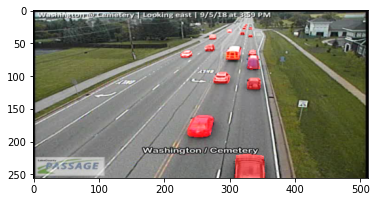

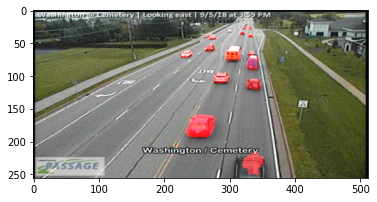

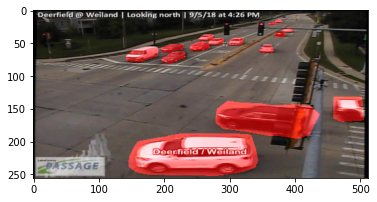

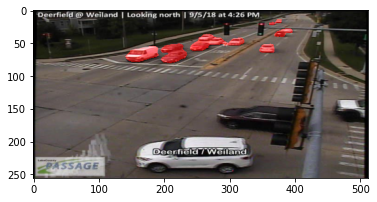

In [ ]:
def display_one_model_mask(model, loader):
    sigmoid = nn.Sigmoid()

    dataiter_train = iter(loader)
    images, targets = dataiter_train.next()

    if next(model.parameters()).is_cuda:
        images_model = images.cuda()
    out = model(images_model)
    out = sigmoid(out)
    out = apply_binary_image_thresholding(out)

    image = images.numpy()[0]
    targets = targets.numpy()[0]
    mask = out.cpu().detach().numpy()[0]

    display_masked_image(image.copy(), targets.copy())
    display_masked_image(image.copy(), mask.copy())

display_one_model_mask(model, val_loader)
display_one_model_mask(model, test_loader)

###Creating bounding boxes around masked regions

<Figure size 1728x720 with 0 Axes>

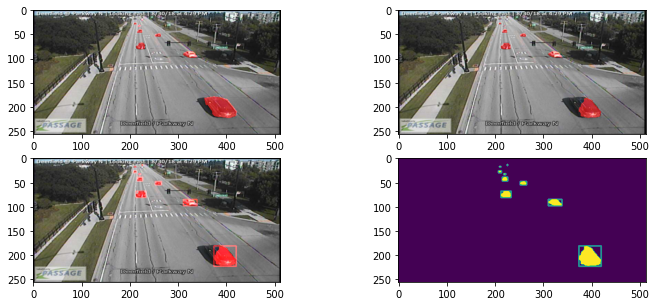

In [ ]:
def find_bounding_boxes(mask, only_bounding_boxes=False):
    mask_orig = mask.copy()
    zeros_array = np.zeros(mask.shape)
    # display_masked_image(mask, zeros_array)

    mask = np.squeeze(mask)
    zeros_array = np.zeros(mask.shape)

    mask = np.uint8(mask * 255)
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if only_bounding_boxes:
       mask = zeros_array.copy()
    idx = 0 
    for cnt in contours[0]:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        mask = cv2.rectangle(mask,(x,y),(x+w,y+h),(1),2)

    mask = np.expand_dims(mask, axis=0)
    # display_masked_image(mask_orig, mask, display=False)
    return mask

def display_one_model_mask_with_boxes(model, loader):
    sigmoid = nn.Sigmoid()

    dataiter_train = iter(loader)
    images, targets = dataiter_train.next()

    if next(model.parameters()).is_cuda:
        images_model = images.cuda()
    out = model(images_model)
    out = sigmoid(out)
    out = apply_binary_image_thresholding(out)

    image = images.numpy()[0]
    targets = targets.numpy()[0]
    mask = out.cpu().detach().numpy()[0]
    bound_boxes = find_bounding_boxes(mask.copy())

    truth_plt = display_masked_image(image.copy(), targets.copy(), display=False)
    masked_plt = display_masked_image(image.copy(), mask.copy(), display=False)
    bounding_plt = display_masked_image(image.copy(), bound_boxes.copy(), display=False)
    bounding_masks_plt = display_masked_image(mask.copy(), bound_boxes.copy(), display=False)

    plt.figure(figsize=(24,10))
    f, axarr = plt.subplots(2,2, figsize=(12,5))
    axarr[0, 0].imshow(truth_plt)
    axarr[0, 1].imshow(masked_plt)
    axarr[1, 0].imshow(bounding_plt)
    axarr[1, 1].imshow(bounding_masks_plt)

display_one_model_mask_with_boxes(model, test_loader)

###Code to draw bounding boxes over image - interim demo **function**

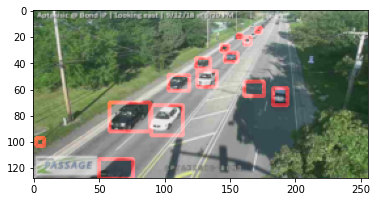

In [ ]:
def draw_bounding_boxes_on_image(image):
    sigmoid = nn.Sigmoid()
    image_model = torch.unsqueeze(image, axis=0)

    if next(model.parameters()).is_cuda:
        image_model = image_model.cuda()
    out = model(image_model)
    out = sigmoid(out)
    out = apply_binary_image_thresholding(out)

    image = image.numpy()
    mask = out.cpu().detach().numpy()
    bound_boxes = find_bounding_boxes(mask.copy(), only_bounding_boxes=True)
    return display_masked_image(image.copy(), bound_boxes.copy(), display=False)

# example usage
image = Image.open(streets_dataset_filepath + '/images/Aptakisic at Bond IP East-3.jpg')
image_transforms = transforms.Compose([transforms.Resize((128, 256)), transforms.ToTensor()])
t_image = image_transforms(image)
masked_image = draw_bounding_boxes_on_image(t_image)  # this function takes in 1 image and returns the same image with the bounding boxes
plt.imshow(masked_image)
plt.show()

### Tracking and ID'ing Bounding Boxes